# Assignment 1
Monday March 4th, 2019 at 23:59

In [2]:
# Imports
# Part 1
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

# Part 2
import folium
from folium import plugins

# Part 3
from scipy.stats import gaussian_kde # KDE
import random
from scipy import stats # Pearson correlation coefficient

# Part 4
from sklearn.utils import shuffle
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Visualize tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus 

### Helping methods used thoughout the assignment

In [3]:
# Returns a subset of the data depending on given dates at cateories (type of crime)
def getSubSet(dates, crimes, data):
    subset = []
    for date in dates:
        subset.append(data.loc[data['Date'].str.contains(date)])
    subset = pd.concat(subset)
    result = []
    for crime in crimes:
        result.append(subset.loc[subset['Category'].str.contains(crime)])
    return pd.concat(result)

## Part 1: Temporal evolution of focus crimes

Police chief Suneman is interested in the temporal development of only a subset of categories, the so-called focus crimes.

In [4]:
focuscrimes = set(['WEAPON LAWS', 'PROSTITUTION', 
                   'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 
                   'BURGLARY', 'ASSAULT', 
                   'DRUNKENNESS', 'DRUG/NARCOTIC', 
                   'TRESPASS', 'LARCENY/THEFT', 
                   'VANDALISM', 'VEHICLE THEFT', 
                   'STOLEN PROPERTY', 'DISORDERLY CONDUCT'])

Underneath are some bar-charts displaying the year-by-year development of each of these categories across the years 2003-2017.

In [5]:
# Import data
data = pd.read_csv("../../Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv") 
print("The overall amount of crimes in the dataset are %d" % len(data))

The overall amount of crimes in the dataset are 2215024


In [6]:
# Filter data to only include the focus crimes
focusData = getSubSet(["/"+str(i) for i in range(2003,2018)],
                      focuscrimes, data)

focusData['Year'] = focusData['Date'].str.split('/', expand=True)[2]

print("The overall amount of focuscrimes in the data are %d" % len(focusData))

The overall amount of focuscrimes in the data are 1251786


Underneath are some bar-charts displaying the year-by-year development of each of the focus categories across the years 2003-2017

In [7]:
# Adds a histogram to a figure 
def createHistogram(group,crimeName,axs, i):
    ax = axs[math.floor(i/2)][(i%2)]
    group['Category'].count().plot(kind='bar', ax=ax)
    years = group['Year'].unique().keys()
    
    ax.set_xticks(range(len(years)))
    if i>11:
        ax.set_xticklabels(years)
    else:
        ax.set_xticklabels([])
        ax.set_xlabel('')
    ax.set_title('Yearly development given the crime %s' % crimeName)

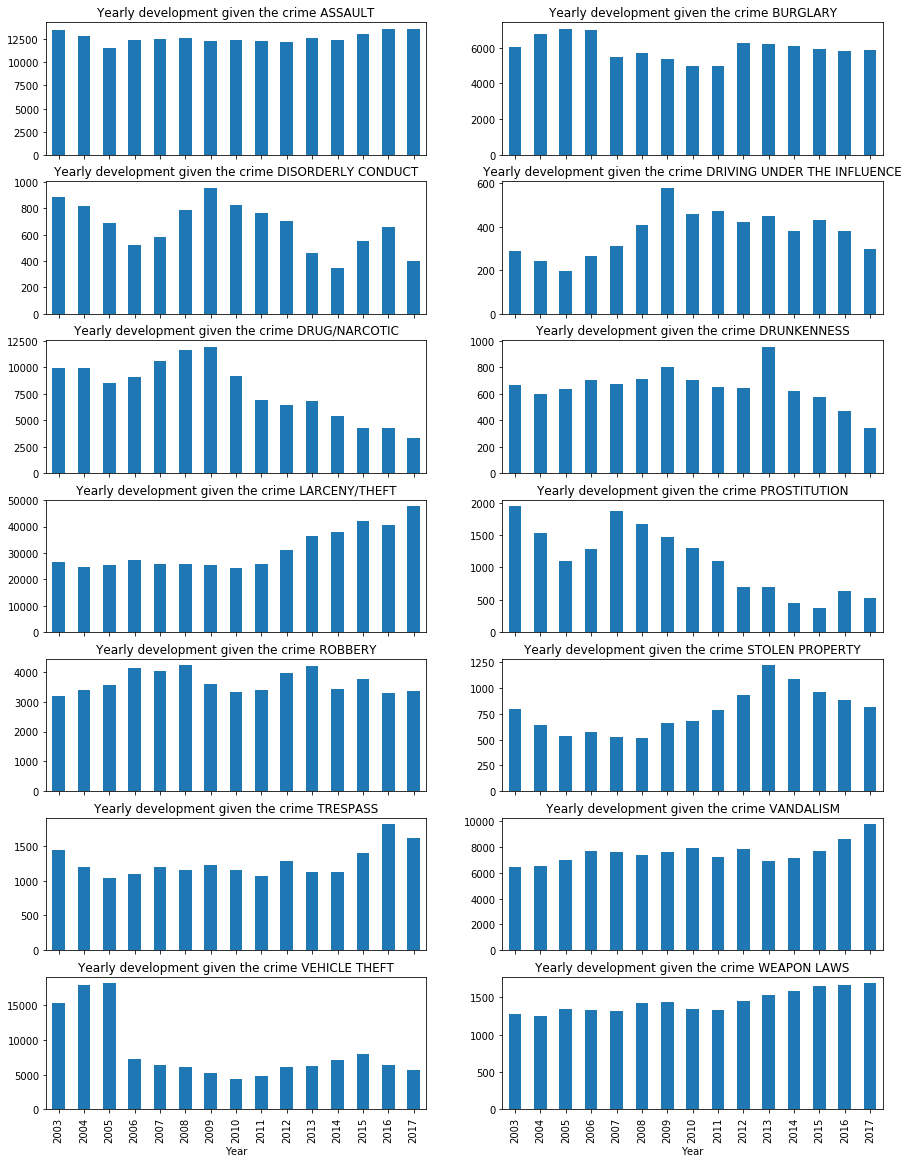

In [7]:
# Display bar-charts
fig, axs = plt.subplots(7, 2, figsize=(15, 20))

i = 0
for crime in sorted(focuscrimes):
    focusCrime = focusData.loc[focusData['Category'] == crime]
    focusCrime = focusCrime.groupby(['Year'])
    createHistogram(focusCrime,crime,axs, i)
    i+=1

plt.show()

## Part 2: Visualizing geo-data

### Plotting a bit
The data is based of a couple of months of data (June-July 2016) for `'DRUG/NARCOTIC'` and the same couple of month for `'LARCENY/THEFT'`.

The geographic data is plotted below in a scatterplot, where the red circles displays each arrest in the category `'DRUG/NARCOTIC'` for in the months june and july for 2016. The blue circles represent each arrest in the category `'LARCENY/THEFT'` for the same time period.

In [8]:
def addCrimeLocations(times, crime, m, fgv, color, data):
    frames = []
    for time in times:
        frames.append(data.loc[data['Date'].str.contains(time)])
    result = pd.concat(frames)
    result = result.loc[result['Category'] == crime]
    
    m = folium.Map([37.77919,-122.41914], zoom_start=12.5)

    for crime in result.values:
        fgv.add_child(folium.CircleMarker(
            location=[crime[10], crime[9]], 
            radius = 3,
            fill=False, 
            color = color, 
            fill_opacity=0.7))
    
    m.add_child(fgv)
    return m

In [9]:
m = folium.Map([37.77919,-122.41914], zoom_start=12.5)
fgv = folium.FeatureGroup(name="Locations")

m = addCrimeLocations(['06/2016','07/2016'], 'LARCENY/THEFT',m, fgv, 'Red', focusData)
m = addCrimeLocations(['06/2016','07/2016'], 'DRUG/NARCOTIC',m, fgv, 'Blue', focusData)

m.add_child(folium.LayerControl())

Now, let's look at heatmaps. 

The map below contains a heatmap of all arrests for `'DRUG/NARCOTIC'` during June-July 2016 

In [10]:
# Creates a heatmap given a time
def heatMap(times, crime, data):
    frames = []
    for time in times:
        frames.append(data.loc[data['Date'].str.contains(time)])
    result = pd.concat(frames)
    result = result.loc[result['Category'] == crime]
    
    m = folium.Map([37.77919,-122.41914], zoom_start=12.5)

    for crime in result.values:
        folium.CircleMarker([crime[9], crime[10]],
                            radius=15,
                            fill_color="#3db7e4", # divvy color
                           ).add_to(m)

    # convert to (n, 2) nd-array format for heatmap
    arr = result[['Y', 'X']].values

    # plot heatmap
    m.add_child(plugins.HeatMap(arr, radius=17))
    return m

In [11]:
heatMap(['06/2016','07/2016'], 'DRUG/NARCOTIC',focusData)

Now this additional heatmap shows all arrests for `'LARCENY/THEFT'` during June-July 2016 

In [12]:
heatMap(['06/2016','07/2016'], 'LARCENY/THEFT',focusData)

# NOT FINISHED
Commentens on the differences. 
* What can you see using the scatter-plots that you can't see using the heatmaps?
* And *vice versa*: what does the heatmaps help you see that's difficult to distinguish in the scatter-plots?

Comments on the effect on the various parameters for the heatmaps. 
* How do they change the picture?

## Part 3: Some single variable plots

Connecting the dots and recreating plots from DAOST but using our own dataset.

The following two crimes will be used as examples throughout the assignment

In [13]:
crime1 = 'MISSING PERSON'
crime2 = 'FRAUD'

The following plot is a jitter-plot based on SF Police data for the crime `missing people` from 2014-2017 in the timeframe 00.00-00.59  

In [14]:

# Filter data
subset = getSubSet(["/2017"],[crime1],data)
hourData = sorted(subset.loc[subset['Time'].str.contains("00:")]['Time'])
print("The overall amount of %s in the timeframe are %d" % (crime1,len(hourData)))

# Find the minute number and make it to an integer
hourDataInt = [0]*len(hourData)
for index, item in enumerate(hourData):
    hourDataInt[index] = int(hourData[index][3:5])

The overall amount of MISSING PERSON in the timeframe are 213


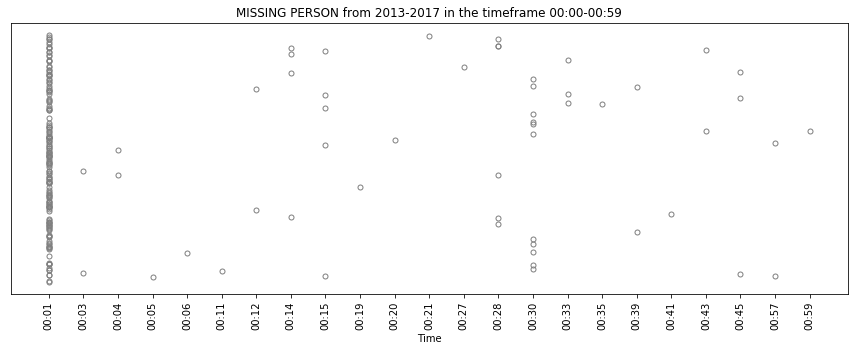

In [15]:
# Create the jitter plot
plt.figure(figsize=(15,5))

y = np.random.random_sample(len(hourData))
plt.plot(hourData,y,'o',markersize=5, color="gray",mfc='none')
plt.gca().axes.get_yaxis().set_visible(False)
plt.title(crime1+' from 2013-2017 in the timeframe 00:00-00:59')
plt.xlabel('Time')
plt.xticks(rotation='vertical')
plt.show()

In [16]:
print("Number of reports for %s at \n- 00:01 are %d crimes,\n- 00:15 are %d crimes\n- 00:30 are %d crimes\n- 00:45 are %d crimes" % 
      (crime1, hourDataInt.count(1),hourDataInt.count(15),hourDataInt.count(30),hourDataInt.count(45)))

Number of reports for MISSING PERSON at 
- 00:01 are 159 crimes,
- 00:15 are 5 crimes
- 00:30 are 11 crimes
- 00:45 are 3 crime


Now it's time for histograms. We will now create two versions of **Figure 2-2**. 

The crimes and timeinternal chosen for these histograms are shown below.

In [17]:
subset1 = getSubSet(["/2014","/2015","/2016","/2017"], [crime1], data)
subset2 = getSubSet(["/2014","/2015","/2016","/2017"],[crime2],data)
print("Amount of data for %s and %s crimes are %d and %d" % (crime1,crime2,len(subset1),len(subset2)))

Amount of data for MISSING PERSON and FRAUD crimes are 18223 and 11326


Then taking the latitude part of the GPS coordinates for each crime and bining the latitudes so that there are 50 bins across the city of SF.

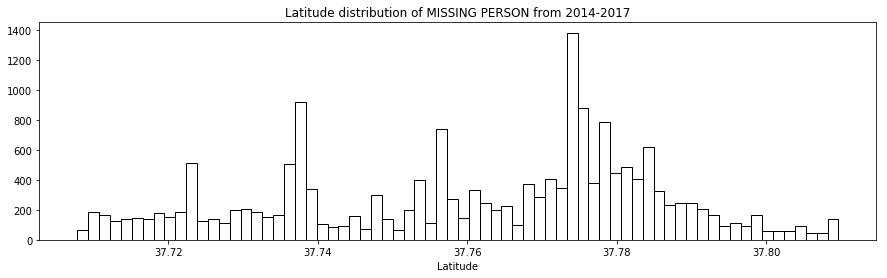

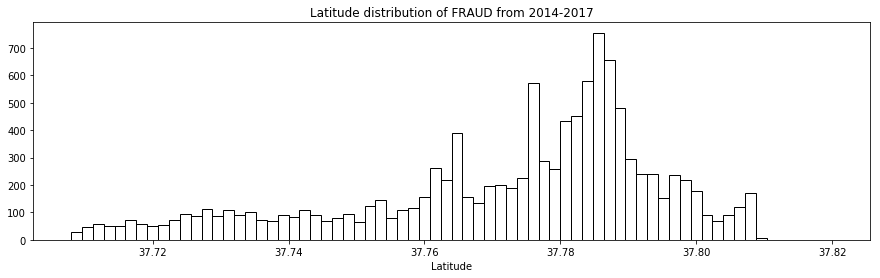

In [18]:
plt.figure(figsize=(15,4))
plt.hist(sorted(subset1['Y']), bins=70,fill=False)
plt.title('Latitude distribution of '+crime1+' from 2014-2017')
plt.xlabel('Latitude')
plt.show()

plt.figure(figsize=(15,4))
plt.hist(sorted(subset2['Y']), bins=70,fill=False)
plt.title('Latitude distribution of '+crime2+' from 2014-2017')
plt.xlabel('Latitude')
plt.show()

Now we want to make the kernel density plot

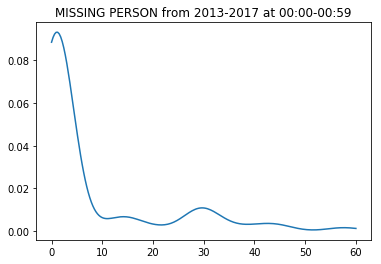

In [19]:
density = gaussian_kde(hourDataInt)
xs = np.linspace(0,60,200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs))
plt.title(crime1+' from 2013-2017 at 00:00-00:59')
plt.show()

Now we will grab 25 random timepoints from the dataset 

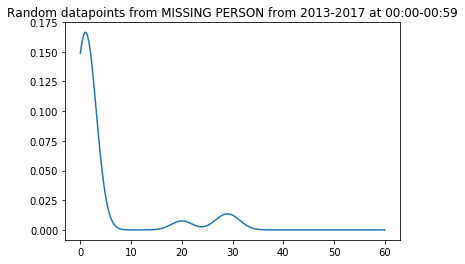

In [20]:
# Find the minute number and make it to an integer
randomData = [] 
for i in range(25):
    randomData.append(random.choice(hourDataInt))
density = gaussian_kde(randomData)
xs = np.linspace(0,60,200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs))
plt.title('Random datapoints from '+crime1+' from 2013-2017 at 00:00-00:59')
plt.show()

# NOT FINISHED
Does this shed light on why I think KDEs can bee misleading? 

To understand to true distribution, the following probability plots are made

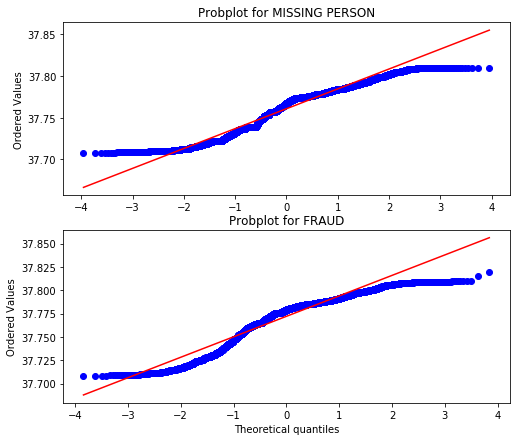

In [21]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(211)
stats.probplot(subset1['Y'], plot=ax)
ax.set_title("Probplot for "+crime1)
ax.set_xlabel("")

ax = fig.add_subplot(212)
stats.probplot(subset2['Y'], plot=ax)
ax.set_title("Probplot for "+crime2)

plt.show()

**Now box plots**. Here, we wnat to use the box plots to visualize fluctuations of how many crimes happen per day. For the 14 focus crimes defined last week.

Calulating the **number of crimes per day** within each category for the entire duration of the data (this should result in 15 datasets, on for each focus crime).


In [22]:
countData = {}
for crime in focuscrimes:
    subset = getSubSet([''],[crime],data)
    countData[crime] = subset.groupby(['Date']).count()

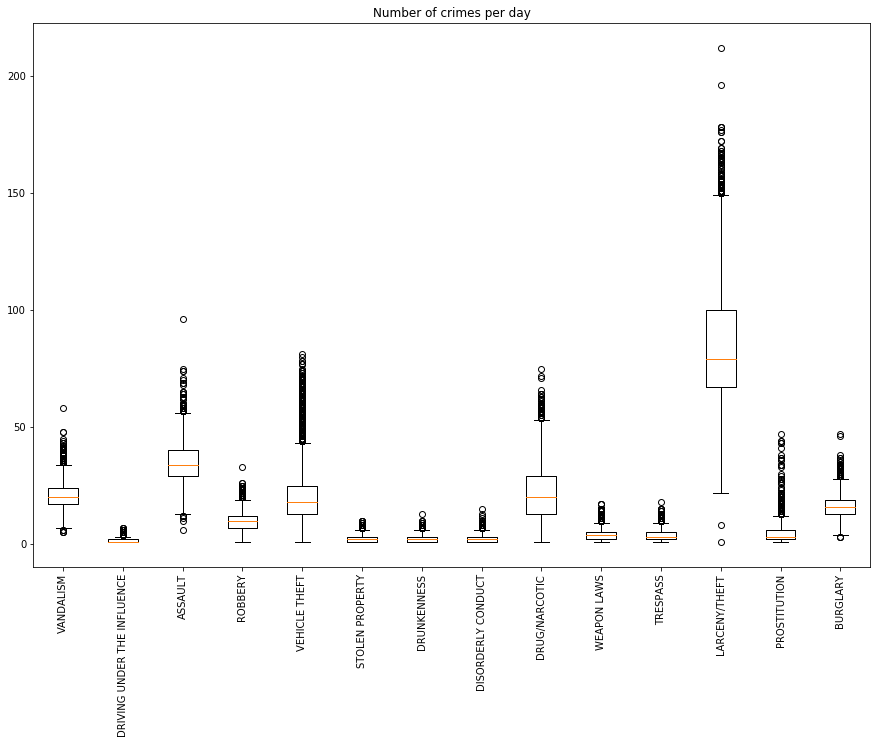

In [23]:
# http://blog.bharatbhole.com/creating-boxplots-with-matplotlib/

fig = plt.figure(1, figsize=(15, 10))

ax = fig.add_subplot(111)

data_to_plt = [countData[crime]['Category'] for crime in focuscrimes]
bp = ax.boxplot(data_to_plt)
ax.set_xticklabels(focuscrimes, rotation='vertical')
ax.set_title('Number of crimes per day')

plt.show()

Or in a different representation:

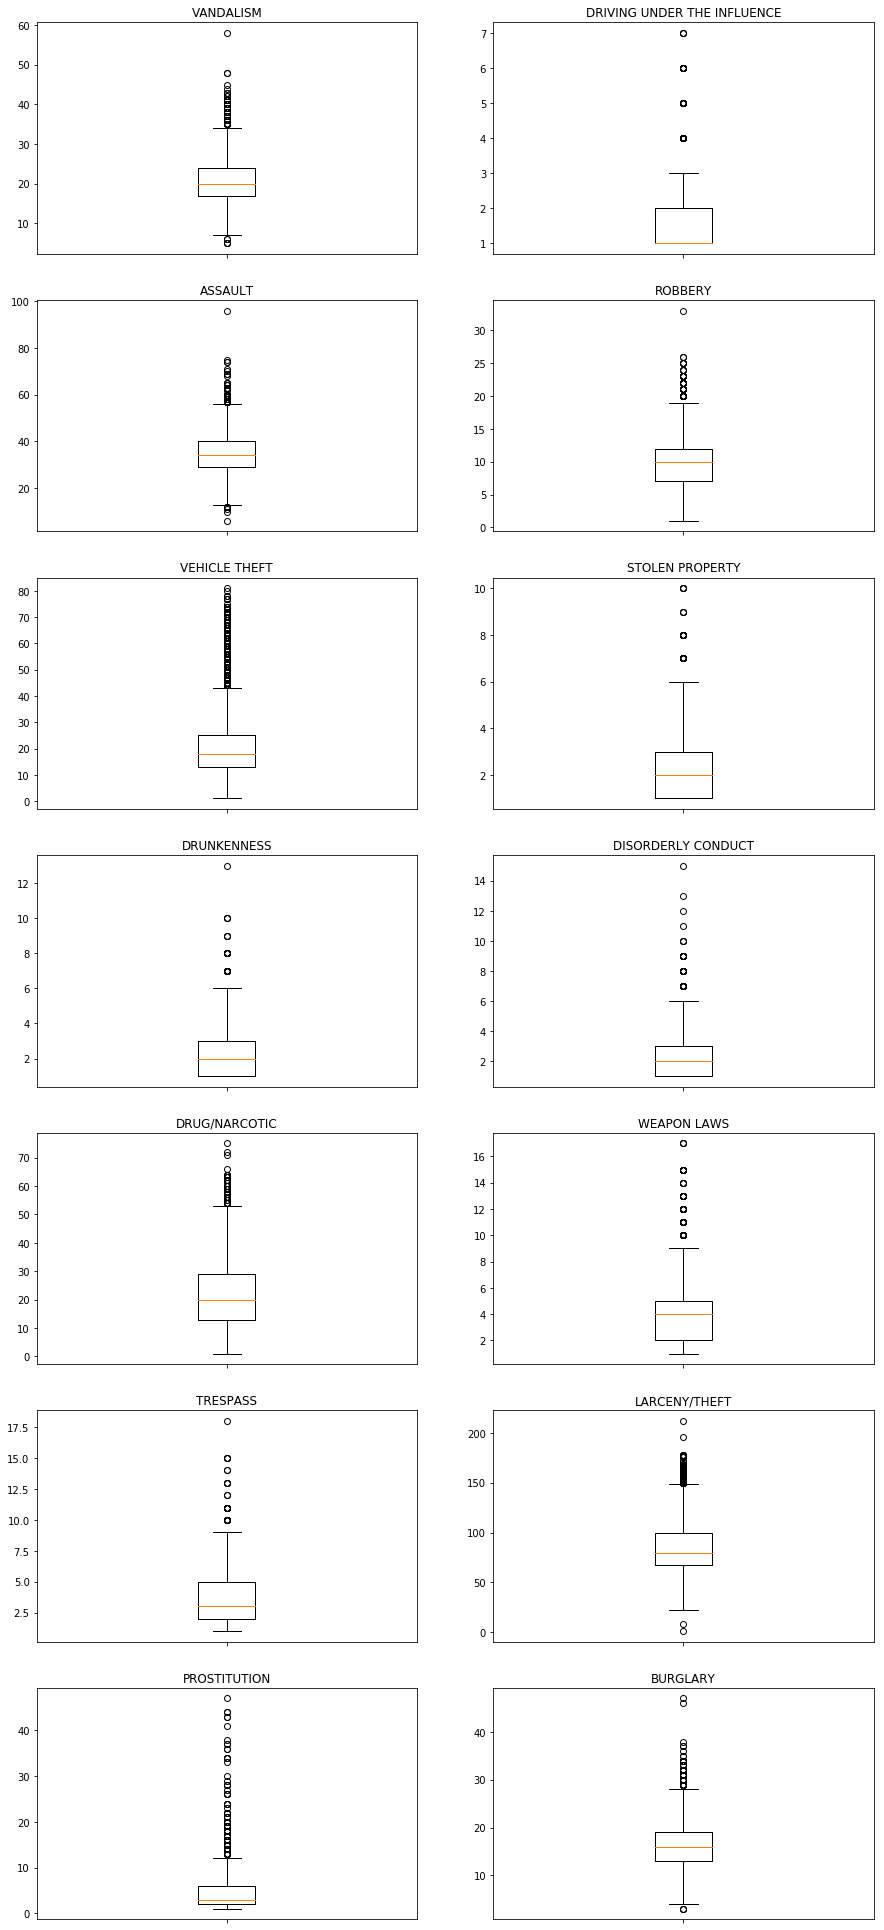

In [24]:
fig = plt.figure(figsize=(15,40))

i = 1
for crime in focuscrimes:
    ax = fig.add_subplot(8,2,i)
    ax.boxplot(countData[crime]['Category'])
    ax.set_title(crime)
    ax.set_xticklabels([])
    ax.set_xlabel('')
    i+=1
plt.show()

These boxplots show how the number of crimes per day for each category is distributed. In contrast to the histograms showing the yearly development for each category in Part 1, these boxplots gives us insight into the number of crimes committed on a daily basis. E.g. In the histograms we can see that the number of assaults committed through the years has been somewhat steady. What we can't see though – but can read from the boxplots – is that although 30-40 crimes of this kind are committed in a normal day, there are days where up to 100 assults are being committed.  

Most of the different crimes are fairly normal distributed. Crimes like prostituion and driving under the influence have some outliers with high values. One could imagine that this is due to the police once in a while focus especially on these crimes some days. All the high value outliers in vehicle theft is probably due to the sudden drop of committed crimes of this type in 2006-present, which we can see in the histograms.

## Part 4: Decision tree

The idea is to pick two crime-types that have *different geographical patterns* and *different temporal patterns* and then use various variables of the real crime data as categories to build a decision tree.

The used variables used in this decision tree are:
* Hour of the day (1-24)
* Day of the week (`Sunday`, ..., `Saturday`)
* Month of the year (1-12)
* PD District (`TENDERLOIN`, etc) 

The variables are initially extracted and converted into integeres as a preprossing of the data, in order to use the data in the decision tree model.

In [25]:
def toInteger(dirc, value):
    return dirc[value]

weekdays = {'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}
districs = {'BAYVIEW':0, 'CENTRAL':1, 'INGLESIDE':2,'MISSION':3,'NORTHERN':4, 'PARK':5, 'RICHMOND':6, 'SOUTHERN':7, 'TARAVAL':8, 'TENDERLOIN':9}

In [26]:
# Getting balanced data with 11000 datapoints from missing children and fraud crimes
subsetTree = pd.concat([subset1[:11000].copy(), subset2[:11000].copy()], ignore_index=True)
subsetTree = shuffle(subsetTree)

# Prepare varible data
treeInput = pd.DataFrame()
treeInput['HourOfDay'] = subsetTree['Time'].str.split(':', expand=True)[0]
treeInput['DayOfWeek'] = subsetTree['DayOfWeek'].apply(lambda x: toInteger(weekdays,x))
treeInput['MonthOfYear'] = subsetTree['Date'].str.split('/', expand=True)[1]
treeInput['PdDistrict'] = subsetTree['PdDistrict'].apply(lambda x: toInteger(districs,x))

# The correct output data
treeOutput = subsetTree['Category']

A decision tree have different parameters, which define the model, some of the more important meassurements are the criterion and the max depth of the tree. 

We try to find the best model by using 10-fold cross validation for 16 different max depths between 1 and 31, and 2 different criterions gini and entropy.

In [27]:
gini_max = [0,0]
entropy_max = [0,0]
for i in np.linspace(1,31,16):
    clf_gini = DecisionTreeClassifier(criterion = "gini", max_depth=i)
    cv_results = cross_validate(clf_gini, treeInput, treeOutput, cv=10, return_train_score=False)
    if np.mean(cv_results['test_score']) > gini_max[0]:
        gini_max[0] = np.max(cv_results['test_score'])
        gini_max[1] = i
    
    clf_entropy = DecisionTreeClassifier(criterion = "entropy", max_depth=i)
    cv_results = cross_validate(clf_entropy, treeInput, treeOutput, cv=10, return_train_score=False)
    if np.mean(cv_results['test_score']) > entropy_max[0]:
        entropy_max[0] = np.max(cv_results['test_score'])
        entropy_max[1] = i

In [28]:
print("The best test score for Gini is %.2f%% with max depth %d" % (gini_max[0]*100,gini_max[1]))
print("The best test score for Entropy is %.2f%% with max depth %d" % (entropy_max[0]*100,entropy_max[1]))


The best test score for Gini is 68.68% with max depth 21
The best test score for Entropy is 68.59% with max depth 21


The best result for the each criterion plotted below, however due to the high value of max dept the trees become very small, and cannot render correctly.

This could be a sign of overfitting, though given that the best model is found through cross validation, it may be because the data for the two crimes are too similar to be easily seperate.

The visualization is using a codeblock from Russel, which can be found on the website https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176

In [35]:
def plotTree(dtree):
    dot_data = StringIO()
    export_graphviz(dtree, 
                    out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True)

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())

In [31]:
# plotting Gini

# recreate the best model
clf_gini = DecisionTreeClassifier(criterion = "gini", max_depth=gini_max[1])
dtree_gini = clf_gini.fit(treeInput, treeOutput) 

# plot the best model 
plotTree(dtree_gini)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0851268 to fit



In [32]:
# plotting Entropy

# recreate the best model
clf_entropy = DecisionTreeClassifier(criterion = "entropy", max_depth=entropy_max[1])
dtree_entropy = clf_entropy.fit(treeInput, treeOutput) 

# plot the best model 
plotTree(dtree_entropy)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0851593 to fit



Since the dataset is balanced, the baseline performance (random guess) is 50%. How good is the classifiers actually?

The best model becomes approximentaly 68-70% (given that the data i shuffled at random the variable changes every time it is run), which is better but not impressive compared to random quessing. More variables may be nessesary to make this approximation even better, since the selected four seem to be able to be optimized.

To give an idea of how the decisian tree looks, a plot with a depth of 2 has been created underneath, though this is very close to random guessing, since the test accuracy is very close to the 50%


The accuracy of gini with a max depth of 2 is 52.98% 


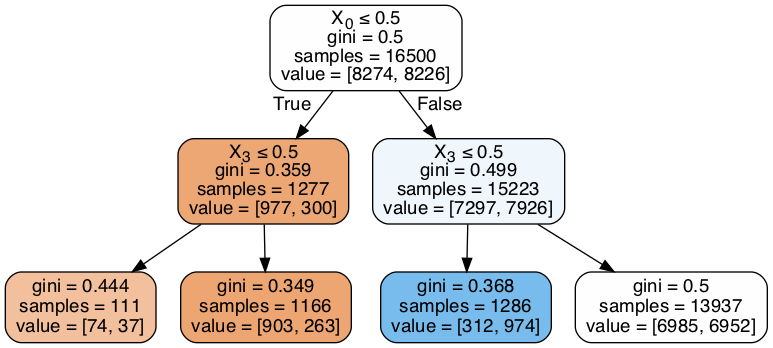

In [37]:
# plotting simple Gini
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# devide data
X_train, X_test, y_train, y_test = train_test_split(treeInput, treeOutput, test_size=0.25)

# recreate the best model
clf_gini = DecisionTreeClassifier(criterion = "gini", max_depth=2)
dtree_gini = clf_gini.fit(X_train, y_train) 

# predicting
y_pred = dtree_gini.predict(X_test)
print("The accuracy of gini with a max depth of 2 is %.2f%% " % 
      (accuracy_score(y_test, y_pred)*100))

# plot the best model 
plotTree(dtree_gini)